<a href="https://colab.research.google.com/github/standard-aaron/deep-learning-projects/blob/main/pyro_markov_outliers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install pyro-ppl

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 722 kB 5.3 MB/s 


In [2]:
import numpy as np
import torch
from torch import nn
import torch.distributions.constraints as constraints
import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
from matplotlib import pyplot as plt
import logging
from IPython import display

# Overview

In this notebook I'm working through a basic example of a inferring the latent state of a Gaussian HMM via SVI + amortized inference.

$Z$ is the latent state; $Z_{t+1} \mid Z_t \sim N(Z_t, \sigma_z)$

$Y$ is the noisy observation of Z; $Y_{t} \mid Z_t \sim N(Z_t, \sigma_y)$

In [70]:
T = 100 # The number of observations per row, all with shared $\sigma_z, \sigma_y$
N = 1000 # The number of rows, each with a unique $\sigma_z, \sigma_y$
BAD_PROB = 0.07
BIG_JUMP_PROB = 0.04
BUFFER = 50

def simulate_data(n=N):
  sigma_z = np.random.chisquare(df=100, size=N)
  sigma_y = np.random.chisquare(df=300, size=N)
  Z = []
  Y = []
  I = []
  z = np.zeros(N)
  for t in range(T + BUFFER):
    bad_err = np.random.binomial(1, BAD_PROB, size=N)
    big_jump = np.random.binomial(1, BIG_JUMP_PROB, size=N)
    z = np.random.normal(z, scale=sigma_z * (1+big_jump*7.0))
    Z.append(z)
    y = np.random.normal(z, scale=sigma_y * (1+bad_err*4.0))
    Y.append(y)
    I.append(bad_err)

  
  Z = torch.tensor(np.vstack(Z).T, dtype=torch.float32)
  Y = torch.tensor(np.vstack(Y).T, dtype=torch.float32)
  Z *= 1/Y.std(axis=1, keepdim=True)
  Z -= Z.mean(axis=1, keepdim=True)
  Y *= 1/Y.std(axis=1, keepdim=True)
  Y -= Y.mean(axis=1, keepdim=True)

  I = torch.tensor(np.vstack(I).T, dtype=torch.float32)
  return Z, Y, I, sigma_z, sigma_y
  
Z, Y, I, sigma_z, sigma_y = simulate_data()

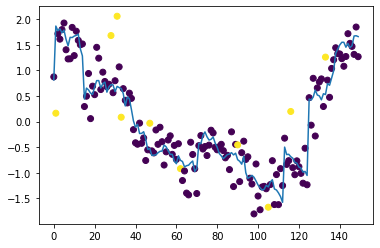

In [71]:
plt.plot(Z[0, :])
plt.scatter(np.arange(T+BUFFER), Y[0, :], c=I[0, :])

In order to perform amortized inference, we need to specify an encoding module $g(x)$ that
maps from (potentially new, unseen) input data $x_i$ to predicted variational
parameters $\phi$.
The reason amortized inference is good is e.g. so that we don't have to
re-train the model
when new data arrives;
instead, we just *predict* the optimal variational parameters using
$g(x_i) = \hat{\phi^*}$.

In this example, our encoder $g(x)$ is a simple MLP with 1 hidden layer.

In [75]:
class Encoder(nn.Module):
  EPS = 1e-2

  def __init__(
      self, 
      lstm_hidden_dim=16, 
      num_layers=2,
      linear_hidden_dim=64,
      buffer=BUFFER
    ):
      super().__init__()
      self.buffer = buffer
      # setup the three linear transformations used
      self.lstm = nn.LSTM(input_size=buffer, hidden_size=lstm_hidden_dim, num_layers=num_layers)
      self.fc_mu_1 = nn.Linear(lstm_hidden_dim, linear_hidden_dim)
      self.fc_mu_2 = nn.Linear(linear_hidden_dim, linear_hidden_dim)
      self.fc_mu_3 = nn.Linear(linear_hidden_dim, 1)
      self.fc_sigma_1 = nn.Linear(lstm_hidden_dim, linear_hidden_dim)
      self.fc_sigma_2 = nn.Linear(linear_hidden_dim, linear_hidden_dim)
      self.fc_sigma_3 = nn.Linear(linear_hidden_dim, 1)
      # setup the non-linearity
      self.relu = nn.ReLU()
      self.softplus = nn.Softplus()

  def forward(self, x):
      x = x.unfold(1, self.buffer, 1)
      hidden_lstm = self.lstm(x)[0][:, :-1, :]
      hidden = self.relu(self.fc_mu_1(hidden_lstm))
      hidden = self.relu(self.fc_mu_2(hidden))
      mu = self.fc_mu_3(hidden)
      hidden = self.relu(self.fc_sigma_1(hidden_lstm))
      hidden = self.relu(self.fc_sigma_2(hidden))
      sigma = self.softplus(self.fc_sigma_3(hidden)) + self.EPS
      #import pdb; pdb.set_trace()
      return mu, sigma

class MyVariationalModule(nn.Module):
  def __init__(self, buffer=BUFFER):
        super().__init__()
        # create the encoder and decoder networks
        self.amortization_encoder = Encoder(buffer=BUFFER)
        self.buffer = BUFFER

  def model(self, data):
    num_sequences = data.shape[0]
    length = data.shape[1]
    z = torch.ones(num_sequences)
    sigma_z = pyro.param("sigma_z", torch.ones(num_sequences), constraint=constraints.positive)
    prob_bad = pyro.param("prob_bad", torch.tensor(6e-2), constraint=constraints.interval(0.001, 0.999))
    prob_big_jump = pyro.param("prob_big_jump", torch.tensor(6e-2), constraint=constraints.interval(0.001, 0.999))
    mult_bad = torch.tensor(10.)
    mult_big_jump = torch.tensor(10.)
    #mult_bad = pyro.param("mult_bad", torch.tensor(10.), constraint=constraints.positive)
    sigma_y = pyro.param("sigma_y", 3*torch.ones(num_sequences), constraint=constraints.positive)
    with pyro.plate("data", dim=-2):
      for t in range(self.buffer, length):
        j = pyro.sample(f"j_{t+1-self.buffer}", dist.Bernoulli(probs=torch.ones(num_sequences)*prob_big_jump))
        z = pyro.sample(f"z_{t+1-self.buffer}", dist.Normal(z, sigma_z*(1+j*mult_big_jump)))
        i = pyro.sample(f"i_{t+1-self.buffer}", dist.Bernoulli(probs=torch.ones(num_sequences)*prob_bad))
        pyro.sample(f"y_{t+1-self.buffer}", dist.Normal(z, sigma_y*(1+i*mult_bad)), obs=data[:, t])

  # define the guide (i.e. variational distribution) q(z|x)
  def guide(self, data):
    # register PyTorch module `encoder` with Pyro
    pyro.module("encoder", self.amortization_encoder)
    # use the encoder to get the parameters used to define q(z|x)
    num_sequences = data.shape[0]
    length = data.shape[1]
    mu, sigma = self.amortization_encoder(data)
    with pyro.plate("data", dim=-2):
      for t in range(self.buffer, length):
        pyro.sample(f"z_{t+1-self.buffer}", dist.Normal(mu[:, t-self.buffer, 0], sigma[:, t-self.buffer, 0]))

In [76]:
def get_params(Y, module):
  mu, sigma = module.amortization_encoder(Y)  
  return mu[..., 0].detach().numpy(), sigma[..., 0].detach().numpy()

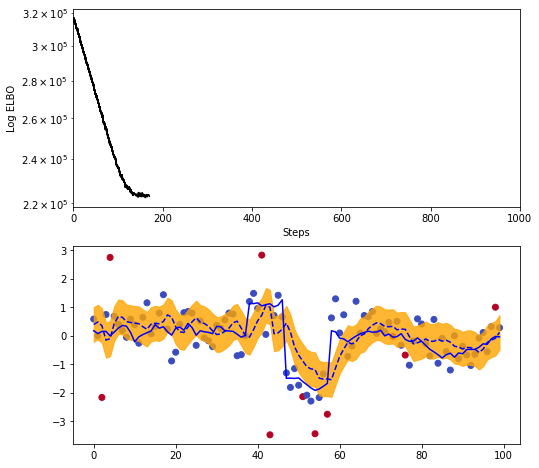

/usr/local/lib/python3.7/dist-packages/pyro/util.py:303: UserWarning: Found vars in model but not guide: {'i_35', 'j_26', 'i_57', 'j_79', 'i_62', 'i_6', 'j_32', 'i_66', 'j_100', 'i_93', 'j_58', 'j_60', 'j_76', 'i_16', 'j_82', 'j_87', 'j_19', 'j_63', 'j_9', 'j_21', 'j_20', 'i_8', 'i_21', 'j_61', 'j_43', 'i_11', 'j_99', 'i_94', 'i_23', 'j_38', 'i_37', 'j_25', 'i_90', 'i_9', 'i_58', 'j_94', 'j_70', 'j_27', 'i_30', 'j_18', 'i_13', 'j_73', 'j_36', 'j_17', 'j_11', 'i_76', 'j_39', 'j_42', 'j_34', 'i_99', 'i_83', 'j_2', 'i_36', 'i_40', 'i_39', 'j_85', 'i_25', 'i_54', 'j_89', 'j_80', 'j_45', 'j_3', 'j_77', 'i_81', 'i_82', 'j_74', 'j_15', 'j_44', 'j_81', 'j_71', 'i_86', 'j_23', 'i_50', 'i_29', 'j_33', 'i_31', 'j_50', 'j_37', 'i_19', 'j_41', 'j_31', 'i_45', 'j_68', 'i_78', 'j_12', 'j_86', 'i_61', 'i_49', 'i_5', 'i_74', 'j_66', 'j_1', 'j_72', 'j_8', 'j_14', 'j_57', 'i_43', 'j_54', 'j_93', 'i_26', 'j_88', 'j_22', 'i_14', 'j_64', 'j_62', 'j_7', 'i_53', 'j_84', 'i_63', 'i_34', 'j_35', 'i_68', 'i_46',

KeyboardInterrupt: ignored

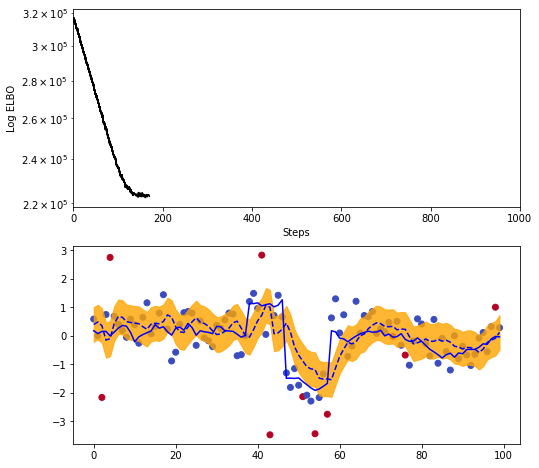

In [77]:
FINETUNE = False

if not FINETUNE:
  pyro.clear_param_store()
  losses = []
  v = MyVariationalModule()

# set up the optimizer
params = {"lr": 1e-2, "betas": (0.99, 0.95)}
optimizer = Adam(params)

# setup the inference algorithm
svi = SVI(v.model, v.guide, optimizer, loss=Trace_ELBO())

n_steps = 5000
# do gradient steps

f, ax = plt.subplots(2, 1)
f.set_size_inches(8, 8)

for step in range(n_steps):
  loss = svi.step(Y)
  losses.append(loss)
  if step % 10 == 0:
    ax[1].clear()
    ax[0].plot(losses, c='k')
    ax[0].set_xlabel("Steps")
    ax[0].set_ylabel("Log ELBO")
    ax[0].set_xlim([0, 1000])
    ax[0].set_yscale('log')
    
    mu, sigma = get_params(Y, v)
    i=2
    
    ax[1].scatter(
        np.arange(T),
        Y[i, BUFFER:],
        label='noisy observations (Y)',
        c=I[i, BUFFER:],
        cmap='coolwarm',
        facecolor='none'
    )
    ax[1].plot(Z[i, BUFFER:], label='latent state (Z)', c='blue')
    ax[1].fill_between(
        np.arange(T),
        mu[i, :] - 2*sigma[i, :],
        mu[i, :] + 2*sigma[i, :],
        color='orange', alpha=0.8
    )
    ax[1].plot(
        np.arange(T),
        mu[i, :],
        color='blue', linestyle='dashed'
    )

    display.clear_output()
    display.display(f)
    

In [78]:
# Predicted mean parameters on the training data
mu, sigma = get_params(Y, v)

Text(0.5, 1.0, 'Training set fit')

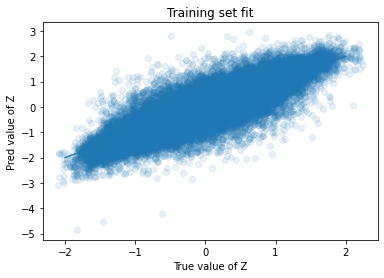

In [79]:
plt.scatter(mu.flatten(), Z[:, BUFFER:].flatten(), alpha=0.1)
plt.plot([-2, 2], [-2, 2])

plt.xlabel('True value of Z')
plt.ylabel("Pred value of Z")
plt.title("Training set fit")

Text(0.5, 1.0, 'Individual examples on training set')

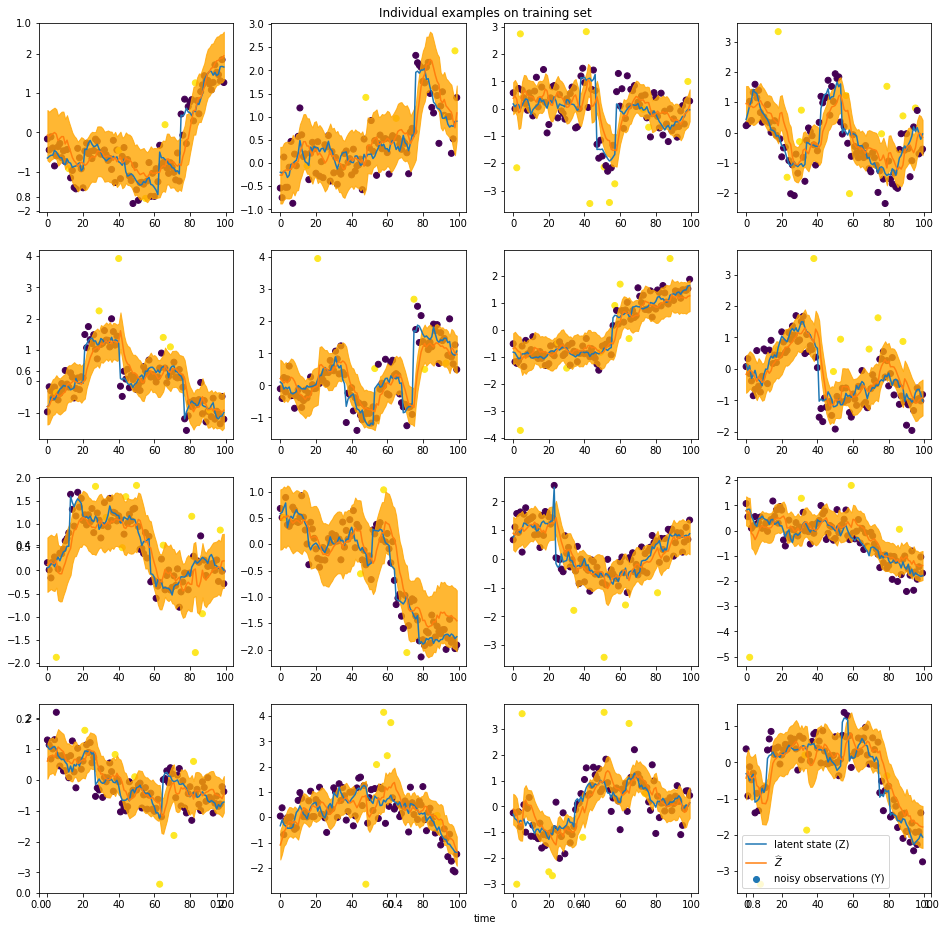

In [80]:
f, axes = plt.subplots(4, 4)
f.set_size_inches(16, 16)
for i in range(16):
  ax = axes[i//4][i%4]
  ax.scatter(
      np.arange(T),
      Y[i, BUFFER:],
      label='noisy observations (Y)',
      c=I[i, BUFFER:],
      facecolor='none'
  )
  ax.plot(Z[i, BUFFER:], label='latent state (Z)')
  ax.fill_between(
      np.arange(T),
      mu[i, :] - 2*sigma[i, :],
      mu[i, :] + 2*sigma[i, :],
      color='orange', alpha=0.8
  )
  ax.plot(mu[i, :], label=r'$\widehat{Z}$')

ax.legend()
f.add_subplot(111, frameon=False)
plt.xlabel('time')
plt.title('Individual examples on training set')


Text(0.5, 1.0, 'Test set fit')

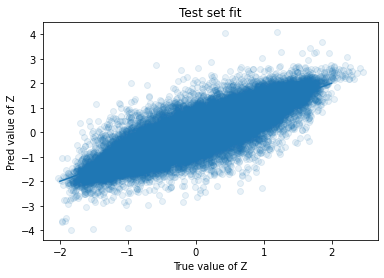

In [81]:
# Compare to holdout data estimates

Z_holdout, Y_holdout, I_holdout, _, _ = simulate_data()

with torch.no_grad():
  mu_holdout, sigma_holdout = get_params(Y_holdout, v)

plt.scatter(mu_holdout.flatten(), Z_holdout[:, BUFFER:].flatten(), alpha=0.1)
plt.plot([-2, 2], [-2, 2])

plt.xlabel('True value of Z')
plt.ylabel("Pred value of Z")
plt.title("Test set fit")

Text(0.5, 1.0, 'Individual examples on holdout set')

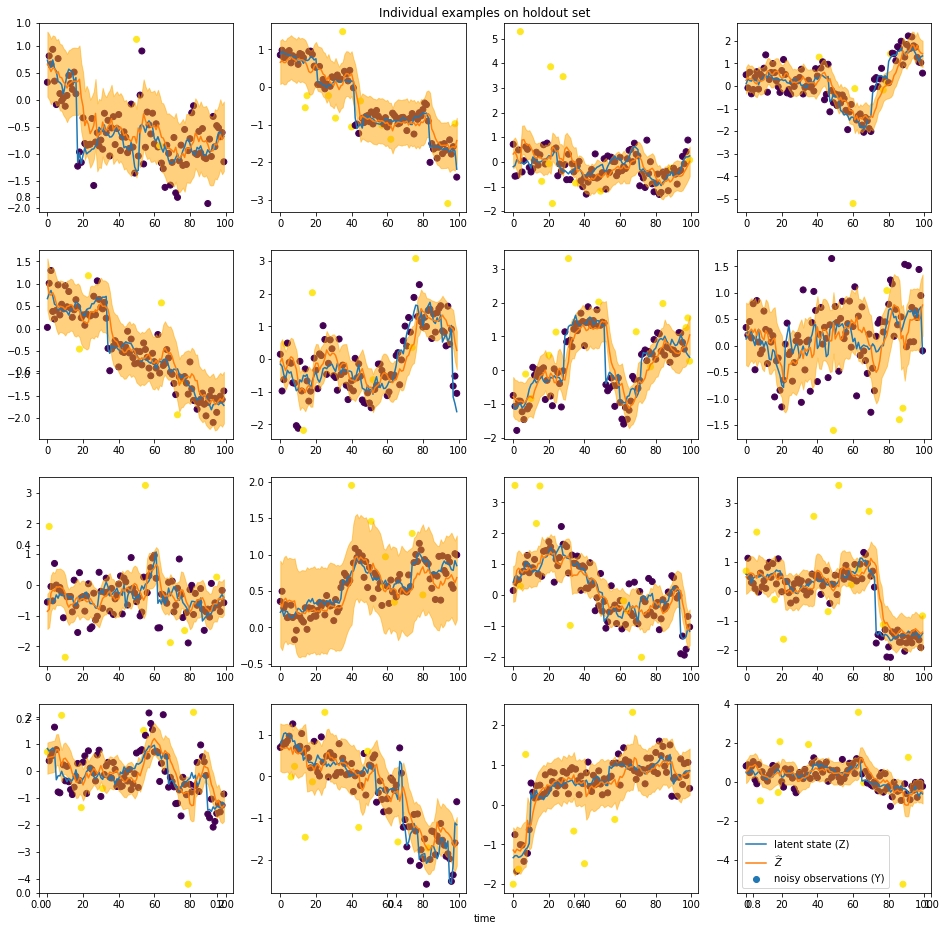

In [82]:
f, axes = plt.subplots(4, 4)
f.set_size_inches(16, 16)
for i in range(16):
  ax = axes[i//4][i%4]
  ax.scatter(
      np.arange(T),
      Y_holdout[i, BUFFER:],
      label='noisy observations (Y)',
      c=I_holdout[i, BUFFER:],
      facecolor='none'
  )
  ax.plot(Z_holdout[i, BUFFER:], label='latent state (Z)')
  ax.plot(mu_holdout[i, :], label=r'$\widehat{Z}$')
  ax.fill_between(
      np.arange(T),
      mu_holdout[i, :] - 2*sigma_holdout[i, :],
      mu_holdout[i, :] + 2*sigma_holdout[i, :],
      color='orange', alpha=0.5
  )
ax.legend()
f.add_subplot(111, frameon=False)
plt.xlabel('time')
plt.title('Individual examples on holdout set')


Text(0.5, 0, 'Coefficient of determination (R^2)')

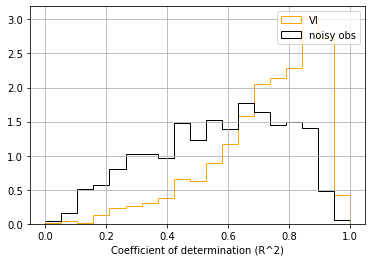

In [83]:
from scipy.stats import stats
R2_y = [stats.linregress(y, z).rvalue**2 for y, z in zip(Y_holdout[:, BUFFER-1:-1], Z_holdout[:, BUFFER:])]
R2_vi = [stats.linregress(m, z).rvalue**2 for m, z in zip(mu_holdout, Z_holdout[:, BUFFER:])]
plt.grid()

plt.hist(R2_vi, bins=np.linspace(0, 1, 20), density=True, histtype='step', label='VI', color='orange')
plt.hist(R2_y, bins=np.linspace(0, 1, 20), density=True, histtype='step', label='noisy obs', color='black')
plt.legend()
plt.xlabel("Coefficient of determination (R^2)")

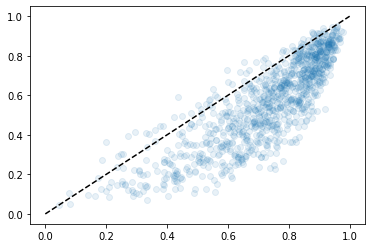

In [84]:
plt.scatter(R2_vi, R2_y, alpha=0.1)
plt.plot([0, 1], [0, 1], c='k', linestyle='dashed')

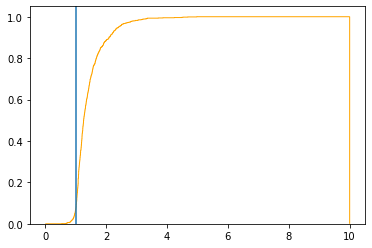

In [85]:
plt.hist(np.array(R2_vi)/np.array(R2_y), bins=np.linspace(0, 10, 2000), density=True, histtype='step', cumulative=True, label='VI', color='orange')
plt.axvline(1)

In [87]:
((
    (mu_holdout - 2*sigma_holdout) > Z_holdout[:, BUFFER:].detach().numpy()
) | (
    (mu_holdout + 2*sigma_holdout) < Z_holdout[:, BUFFER:].detach().numpy()
)).mean()

0.08314